# Image procesing

In [1]:
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import img_to_array
from PIL import Image

In [2]:
RESIZED_IMAGE_WIDTH = 20                    # width of resized image
RESIZED_IMAGE_HEIGHT = 30                   # height of resized image

DATASET_PATH = os.getcwd() + '/dataset/'    # path to dataset

In [3]:
X = []                          # list of alphabet images
y = []                          # list of labels        

In [4]:
for char in os.listdir(DATASET_PATH):
    print(char)
    if len(char) > 1:           # if the folder name is more than 1 character, it is nto a character
        continue
    for img in os.listdir(DATASET_PATH + char):
        if not img.endswith('.png'):            # if the file is not a png file, skip it
            continue
        image = cv2.imread(DATASET_PATH + char + '/' + img, cv2.IMREAD_GRAYSCALE)       # read the image
        imageROI = cv2.resize(                                                          # resize the image
            image, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))
        X.append(img_to_array(Image.fromarray(imageROI)))           # add the image to the list
        y.append(ord(char))                                         # add the label to the list
X = np.array(X)                 # convert the list to a numpy array
y = np.array(y)                 # convert the list to a numpy array

R
U
9
7
I
N
G
6
Z
1
8
T
S
A
F
H
M
J
C
D
V
Q
4
X
3
E
B
K
L
2
Y
5
P
W


In [5]:
print(X.shape)
print(y.shape)

(10000, 30, 20, 1)
(10000,)


# Initial Analysis and Data Wrangling

### Scale b/w 0 and 1

In [6]:
X /= 255.0                              # normalize the data

Print frequency of each character in the list

In [7]:
temp = set(y)
for t in temp :
    print('Occurance count of ' + chr(t) + ' : ' + str(len(y[y == t])))

Occurance count of 1 : 304
Occurance count of 2 : 275
Occurance count of 3 : 311
Occurance count of 4 : 301
Occurance count of 5 : 289
Occurance count of 6 : 262
Occurance count of 7 : 307
Occurance count of 8 : 309
Occurance count of 9 : 303
Occurance count of A : 311
Occurance count of B : 320
Occurance count of C : 324
Occurance count of D : 297
Occurance count of E : 270
Occurance count of F : 313
Occurance count of G : 285
Occurance count of H : 277
Occurance count of I : 305
Occurance count of J : 316
Occurance count of K : 289
Occurance count of L : 4
Occurance count of M : 287
Occurance count of N : 322
Occurance count of P : 295
Occurance count of Q : 331
Occurance count of R : 294
Occurance count of S : 325
Occurance count of T : 289
Occurance count of U : 327
Occurance count of V : 297
Occurance count of W : 313
Occurance count of X : 344
Occurance count of Y : 286
Occurance count of Z : 318


In [8]:
import seaborn

In [9]:
temp_df = pandas.DataFrame({
    'labels' : [t for t in temp],
    'Count' : [len(y[y == t]) for t in temp]
})

Text(0.5, 1.0, 'Label distribution in CAPTCHAS')

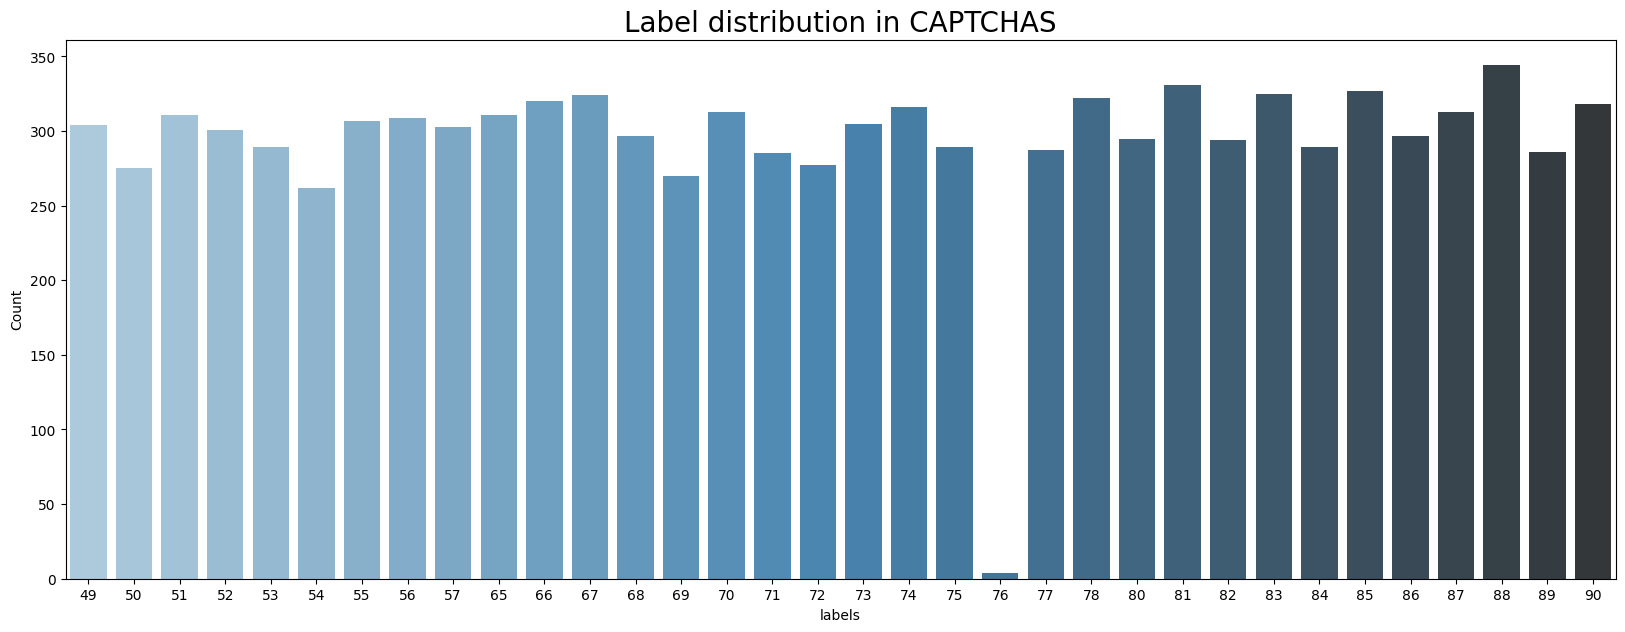

In [10]:
plt.figure(figsize = (20,7))
seaborn.barplot(x = 'labels', y = 'Count', data = temp_df, palette = 'Blues_d')
plt.title('Label distribution in CAPTCHAS', fontsize = 20)

### One hot encoding

In [11]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

y_combine = LabelEncoder().fit_transform(y)
y_one_hot = OneHotEncoder(sparse = False).fit_transform(y_combine.reshape(len(y_combine),1))

In [12]:
print('letter n : ' + str(y[1]))
print('label : ' + str(y_combine[1]))
print('Count : ' + str(len(y_combine[y_combine == y_combine[1]])))

letter n : 82
label : 25
Count : 294


In [13]:
info = {y_combine[i] : y[i] for i in range(len(y))}

In [14]:
print(info)

{25: 82, 28: 85, 8: 57, 6: 55, 17: 73, 22: 78, 15: 71, 5: 54, 33: 90, 0: 49, 7: 56, 27: 84, 26: 83, 9: 65, 14: 70, 16: 72, 21: 77, 18: 74, 11: 67, 12: 68, 29: 86, 24: 81, 3: 52, 31: 88, 2: 51, 13: 69, 10: 66, 19: 75, 20: 76, 1: 50, 32: 89, 4: 53, 23: 80, 30: 87}


# Train test split

In [15]:
print(X.shape)
print(y_one_hot.shape)  # one hot encoded form

(10000, 30, 20, 1)
(10000, 34)


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.2, random_state = 1)

# Model Creation

In [18]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization

from keras.layers import Dropout
from keras.layers import Input

In [19]:
print(X_train.shape)
print(y_train.shape)

(8000, 30, 20, 1)
(8000, 34)


In [20]:
print(X_test.shape)
print(y_test.shape)

(2000, 30, 20, 1)
(2000, 34)


In [21]:
def conv_layer (filterx) :
    model = Sequential()
    model.add(Conv2D(filterx, (3,3), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    return model

In [22]:
def dens_layer (hiddenx) :
    model = Sequential()
    model.add(Dense(hiddenx, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    return model

In [23]:
def cnn (filter1, filter2, filter3, hidden1, hidden2) :
    model = Sequential()
    model.add(Input((X.shape[1:])))
    
    model.add(conv_layer(filter1))
    model.add(conv_layer(filter2))
    model.add(conv_layer(filter3))
    
    model.add(Flatten())
    model.add(dens_layer(hidden1))
    model.add(dens_layer(hidden2))
    
    model.add(Dense(y_one_hot.shape[1], activation = 'softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

# Data augmentation and Oversampling

Oversampled images

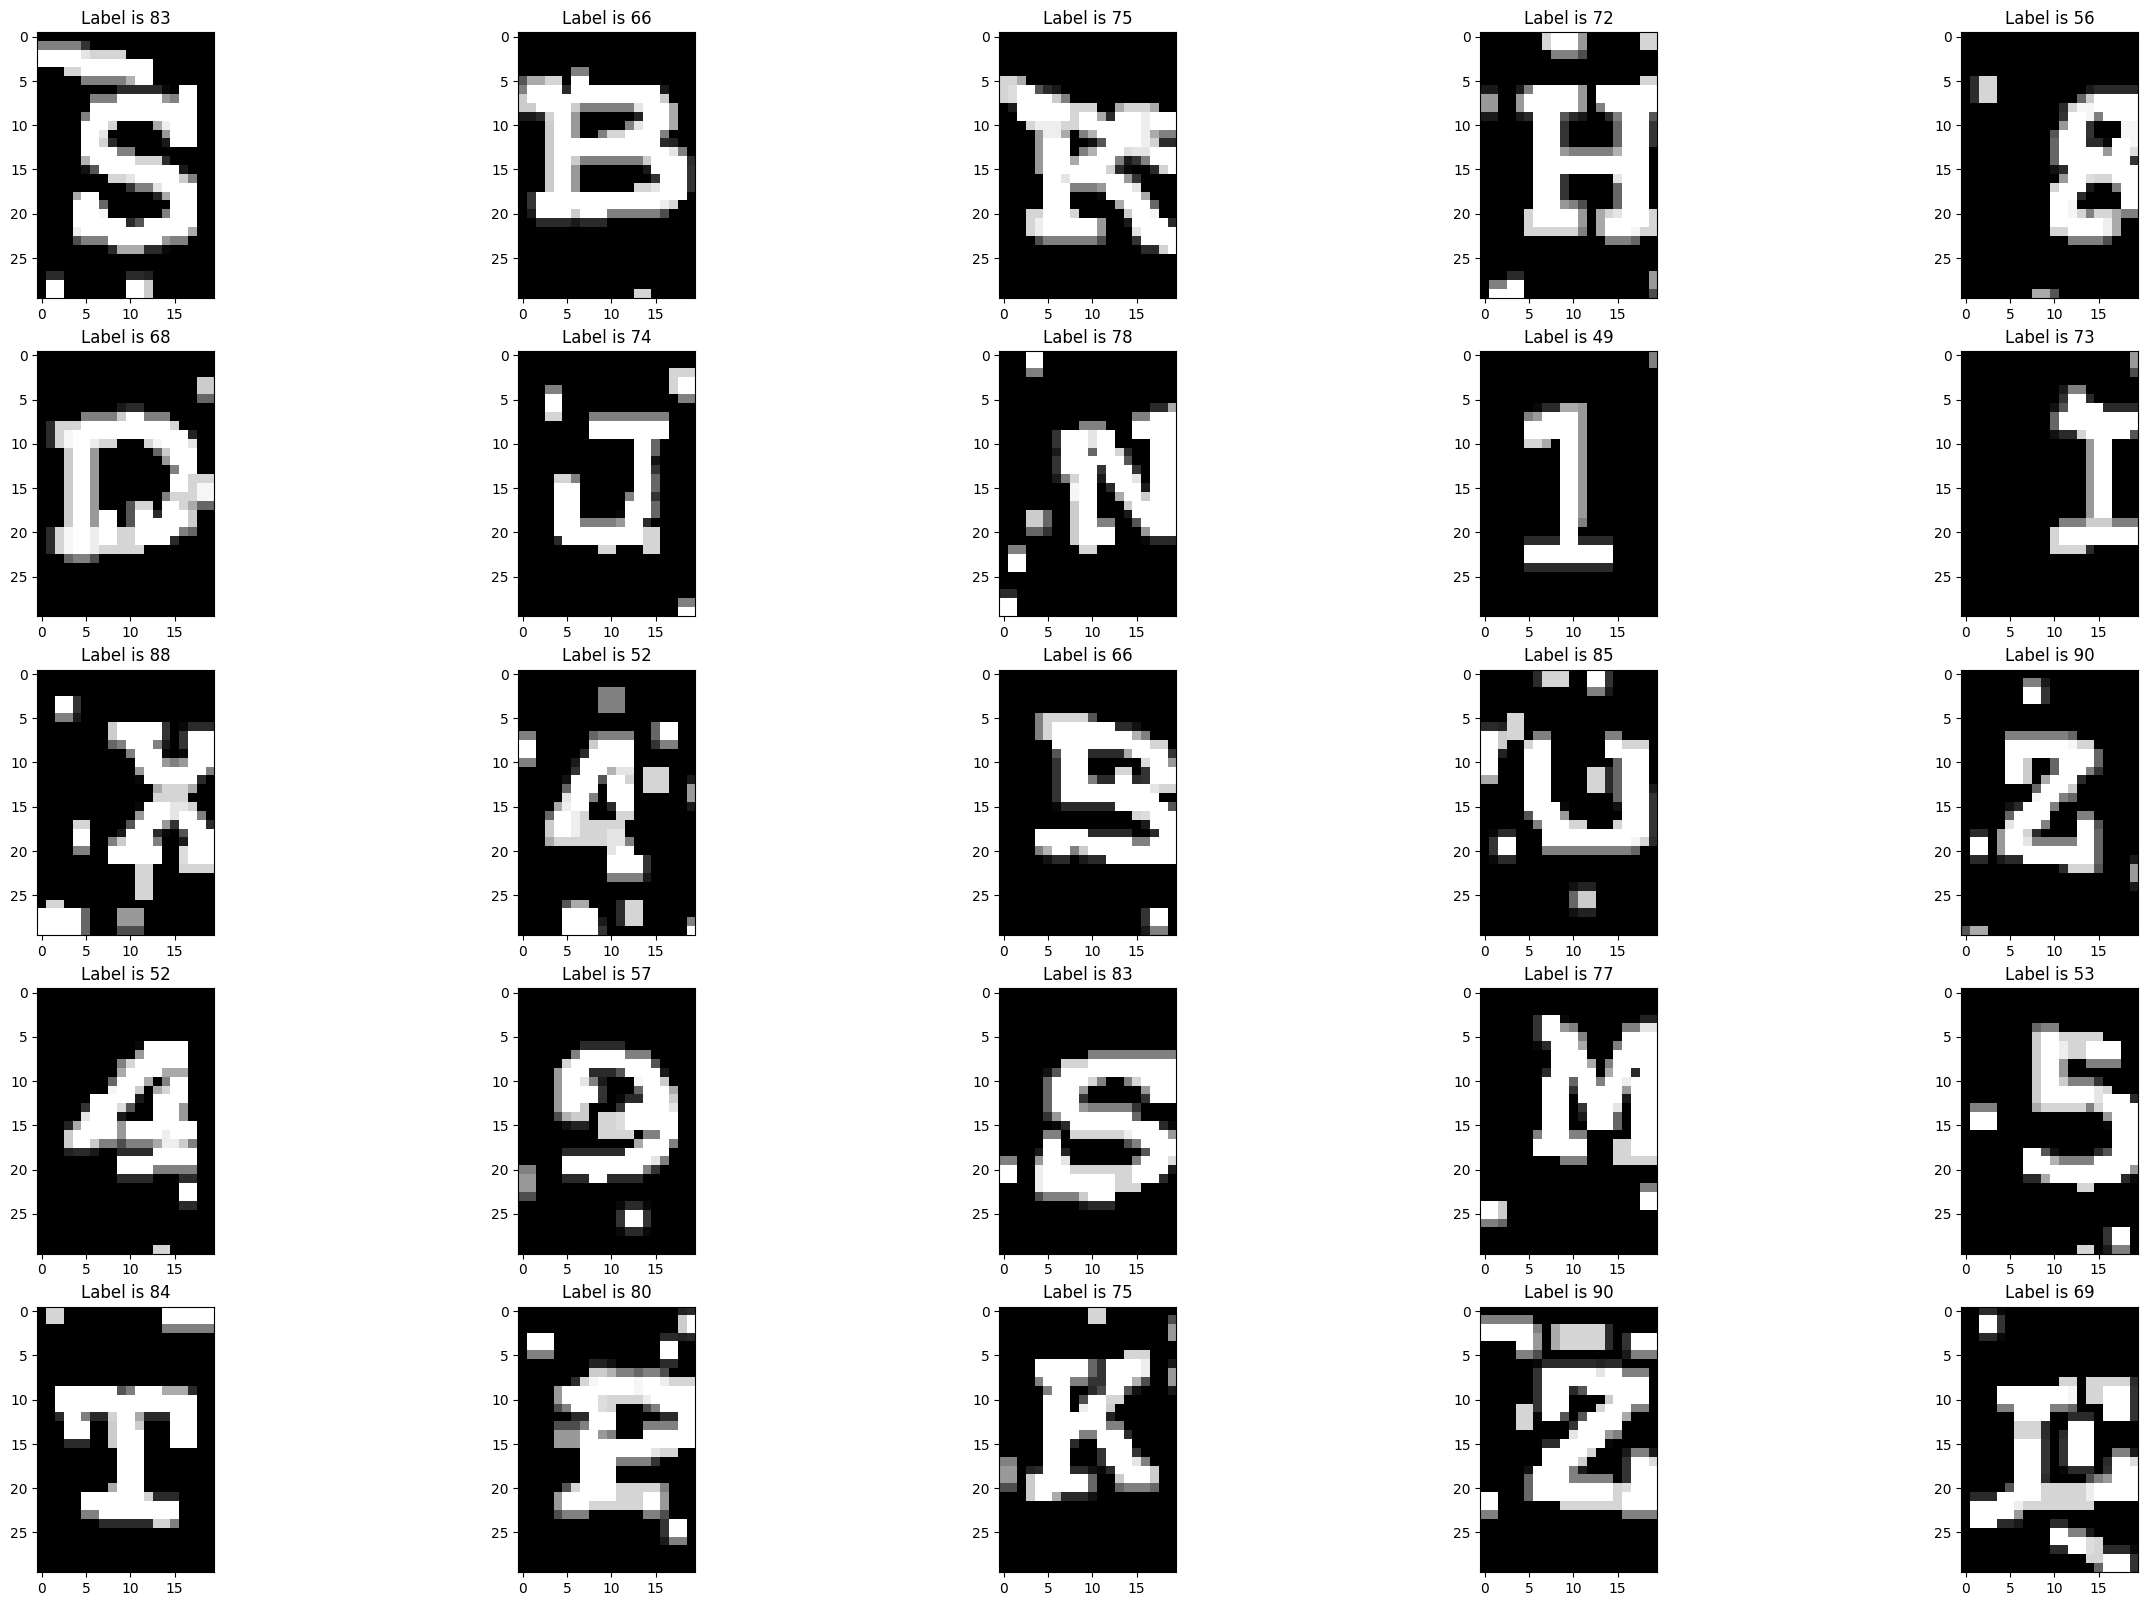

In [24]:
plt.figure(figsize = (30,20))

hi = 7800
lo = 5000

for i in range(25) :
    plt.subplot(5,5,i+1)
    x = np.random.randint(lo, hi)
    plt.imshow(X_train[x], 'gray')
    plt.title('Label is ' + str(info[np.argmax(y_train[x])]))
plt.show()

### ImageDataGenerator

In [25]:
from keras.preprocessing.image import ImageDataGenerator

In [26]:
traingen = ImageDataGenerator(rotation_range = 5, width_shift_range = [-2,2])
traingen.fit(X_train)

In [27]:
train_set = traingen.flow(X_train, y_train)

In [28]:
trainX, trainy = train_set.next()

# Model Training

In [29]:
model = cnn(128, 32, 16, 32, 32)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 15, 10, 128)       1792      
                                                                 
 sequential_2 (Sequential)   (None, 8, 5, 32)          37024     
                                                                 
 sequential_3 (Sequential)   (None, 4, 3, 16)          4688      
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 sequential_4 (Sequential)   (None, 32)                6304      
                                                                 
 sequential_5 (Sequential)   (None, 32)                1184      
                                                                 
 dense_2 (Dense)             (None, 34)                1

### ModelCheckpoint and ReduceLROnPlateau
Used ModelCheckpoint to retain the best perfroming model (in terms of loss), and ReduceLROnPlateau to reduce the learning in case the model stops improving.

In [30]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
checkp = ModelCheckpoint('./result_model.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)

In [31]:
reduce = ReduceLROnPlateau(monitor = 'val_loss', patience = 20, verbose = 1)

In [32]:
print(X_train.shape)
print(y_train.shape)

(8000, 30, 20, 1)
(8000, 34)


In [33]:
history = model.fit(
    traingen.flow(X_train, y_train, batch_size = 32), 
    validation_data = (X_test, y_test), 
    epochs = 50, 
    steps_per_epoch = len(X_train)/32, 
    callbacks = [checkp])

Epoch 1/50


2022-11-18 01:53:19.129218: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


250/250 [==============================] - ETA: 0s - loss: 3.3827 - accuracy: 0.1025
Epoch 1: val_loss improved from inf to 3.67264, saving model to ./result_model.h5
250/250 [==============================] - 18s 67ms/step - loss: 3.3827 - accuracy: 0.1025 - val_loss: 3.6726 - val_accuracy: 0.0375
Epoch 2/50
249/250 [============================>.] - ETA: 0s - loss: 2.3071 - accuracy: 0.3436
Epoch 2: val_loss improved from 3.67264 to 2.90308, saving model to ./result_model.h5
250/250 [==============================] - 12s 50ms/step - loss: 2.3052 - accuracy: 0.3441 - val_loss: 2.9031 - val_accuracy: 0.1375
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 1.5639 - accuracy: 0.5624
Epoch 3: val_loss improved from 2.90308 to 1.23959, saving model to ./result_model.h5
250/250 [==============================] - 13s 51ms/step - loss: 1.5639 - accuracy: 0.5624 - val_loss: 1.2396 - val_accuracy: 0.7220
Epoch 4/50
250/250 [==============================] - ETA: 0s - loss: 

Text(0.5, 1.0, 'Model accuracy wrt Epoch')

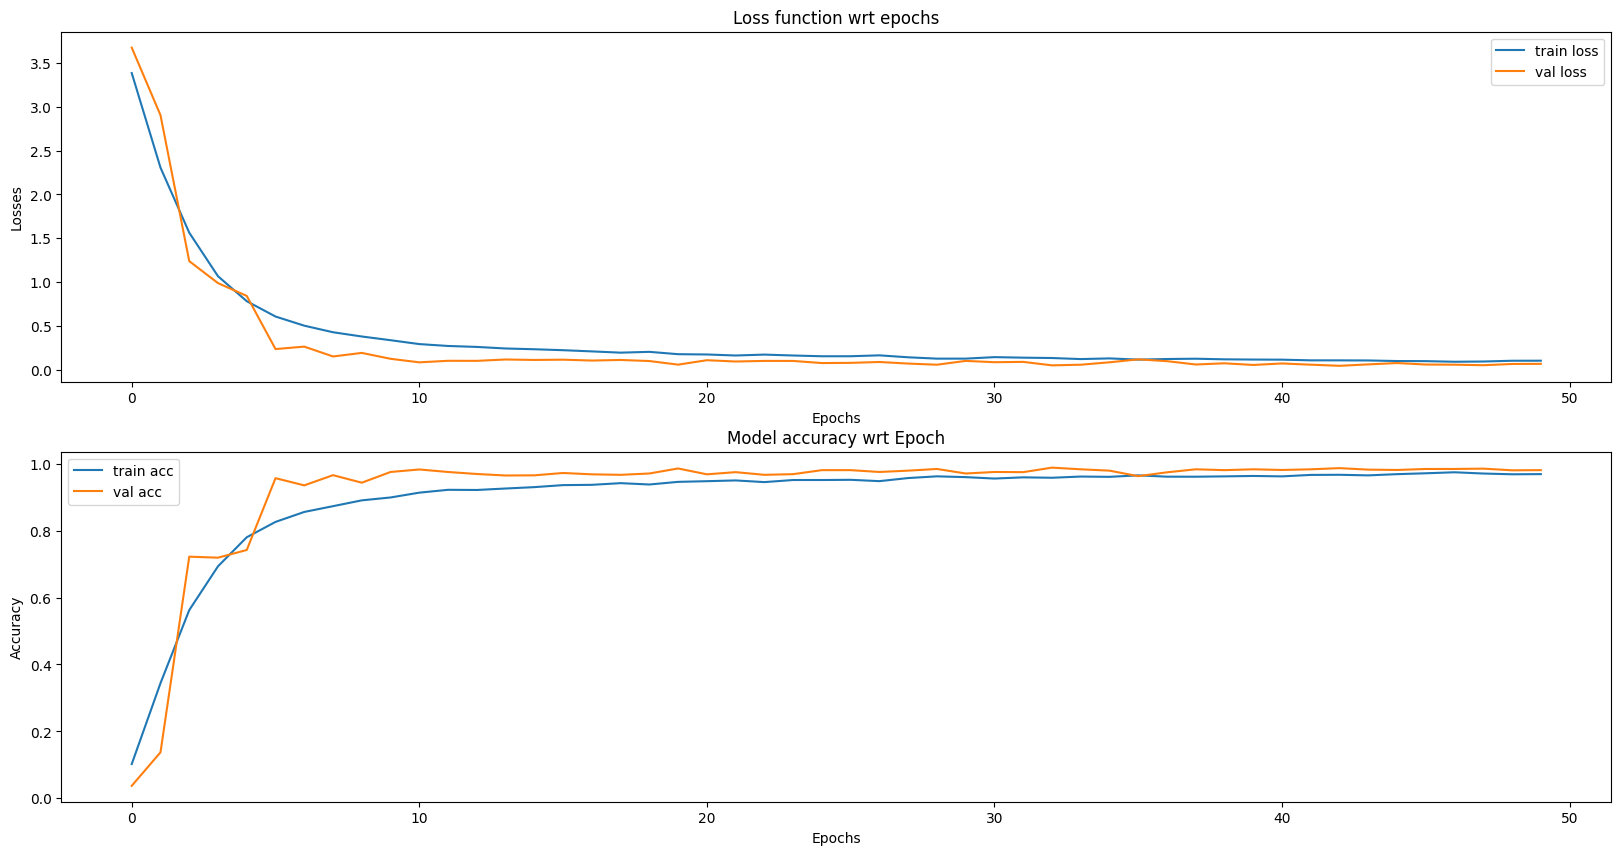

In [34]:
plt.figure(figsize = (20,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['train loss','val loss'])
plt.title('Loss function wrt epochs')

plt.subplot(2,1,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train acc' , 'val acc'])
plt.title('Model accuracy wrt Epoch')

# Prediction

In [35]:
from keras.models import load_model

In [36]:
model = load_model('./result_model.h5')

In [37]:
pred = model.predict(X_test)

63/63 [==============================] - 1s 8ms/step


Perfromed numpy argmax to obtain the value which has the highest probability of being the truth value.

In [43]:
pred = np.argmax(pred, axis = 1)
yres = np.argmax(y_test,axis= 1)


In [44]:
from sklearn.metrics import accuracy_score, classification_report

In [45]:
target_name = []
for i in sorted(info) :
    target_name.append(info[i])

In [46]:
target_name

[49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90]

In [47]:
print('Accuracy : ' + str(accuracy_score(yres, pred)))

Accuracy : 0.9865


# Testing on samples

In [62]:
def get_demo (img_path) :
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img, 'gray')
    plt.axis('off')
    plt.show()

    # get binary image
    thresh = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
    # remove noise from image
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE,
                             np.ones((3, 3), np.uint8))
    # get dilated image
    dilate = cv2.dilate(close, np.ones((2, 2), np.uint8), iterations=1)
    # invert image colors
    image = cv2.bitwise_not(dilate)

    plt.imshow(image, 'gray')
    plt.axis('off')
    plt.show()
    
    # get separate characters from captcha
    image_list = [image[5:40, i:i+36] for i in range(0, 180, 36)]
    
    # append characters to list as array
    Xdemo = []
    for i in range(5) :
        image_list[i] = cv2.resize(image_list[i], (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))
        image_list[i] = cv2.dilate(
            image_list[i], np.ones((2, 2), np.uint8), iterations=1)
        cv2.imshow('image', image_list[i])
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        Xdemo.append(img_to_array(Image.fromarray(image_list[i])))
    Xdemo = np.array(Xdemo)

    # predict characters
    ydemo = model.predict(Xdemo)
    ydemo = np.argmax(ydemo, axis = 1)
    
    for res in ydemo :
        print(chr(info[res]))
    print(img_path[-9:])
    cv2.destroyAllWindows()

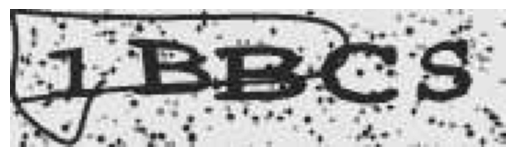

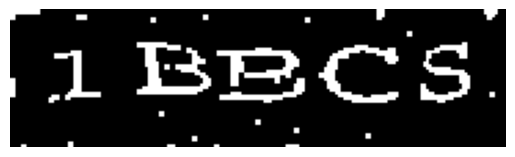

1/1 [==============================] - 0s 19ms/step
W
W
W
N
N
1BBCS.png


: 

In [63]:
get_demo('./test/1BBCS.png')